## Intro

This notebook covers:</br>
- Creating PyTorch Dataset and DataLoader
- Defining GRU network
- **Training process explained step by step**

Interesting [notebooks](https://awesomeopensource.com/project/bentrevett/pytorch-sentiment-analysis?categoryPage=19) regarding Pytorch + RNNs

## Prepare

Install packages

In [1]:
!pip install git+https://git@github.com/kavgan/word_cloud.git &> /dev/null
!pip install -q spacy

Imports

In [2]:
# deep learning
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# load data
from google_drive_downloader import GoogleDriveDownloader as gdd
from pathlib import Path

# visualization
import matplotlib.pyplot as plt
from word_cloud.word_cloud_generator import WordCloud
from IPython.core.display import HTML

# data science
import pandas as pd
import spacy
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score

# other
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

Settings

In [3]:
TRAIN_DATASET_PATH = '/tmp/train-en.tsv'
EVAL_DATASET_PATH = '/tmp/eval-en.tsv'
TRAIN_DATASET_GDRIVE_ID = '196d23FA_YFJTpu_yDRpXjBG6DPKs9WI2'
EVAL_DATASET_GDRIVE_ID = '1p4O7Y2ePV17gPbwPTOio5EM7QMXHFI5V'
RANDOM_STATE = 42
LABEL = 'label'
TEXT = 'text'
PAD = '<PAD>'
UNK = '<UNK>'

Check device

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Number of gpu devices:', torch.cuda.device_count())
if torch.cuda.device_count() > 0:
    print('Device name:', torch.cuda.get_device_name(0))
print('Device type:', device)
print('PyTorch version:', torch.__version__)

Number of gpu devices: 0
Device type: cpu
PyTorch version: 1.9.0+cu102


Get data

In [5]:
def download_data_from_gdrive(local_path, gdrive_file_id):
    if not Path(local_path).is_file():
        gdd.download_file_from_google_drive(
            file_id=gdrive_file_id,
            dest_path=local_path,
        )

In [6]:
download_data_from_gdrive(TRAIN_DATASET_PATH, TRAIN_DATASET_GDRIVE_ID)

## Preprocess

Load data

In [7]:
df = pd.read_csv(TRAIN_DATASET_PATH, delimiter='\t', names=[LABEL, TEXT])
df.sample(5)

,label,text
14433,weather/find,will it rain saturday
10189,reminder/set_reminder,remind me to go to bed early
23373,reminder/show_reminders,Show reminder for Saturday
11379,weather/find,Should I pack a sweater tomorrow?
27702,weather/find,What will the weather be like on my birthday?


In [8]:
df.drop_duplicates(subset=[TEXT], inplace=True)

In [9]:
df[LABEL].value_counts()

weather/find                11336
alarm/set_alarm              4180
reminder/set_reminder        4136
alarm/cancel_alarm           1422
reminder/cancel_reminder      850
alarm/show_alarms             774
reminder/show_reminders       657
alarm/modify_alarm            402
alarm/time_left_on_alarm      296
alarm/snooze_alarm            291
weather/checkSunset           119
weather/checkSunrise           88
Name: label, dtype: int64

In [10]:
data = df[TEXT].tolist()
labels = df[LABEL].tolist()

In [11]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [12]:
def preprocess(text):
    text = text.lower()
    text = text.strip() 
    text = ' '.join(text.split())  # replace whitespace with single space

    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc if not token.is_punct]
    #tokens = [token for token in tokens if len(token) > 1]

    return ' '.join(tokens)

In [13]:
data_clean = [preprocess(x) for x in tqdm(data)]

100%|██████████| 24551/24551 [01:11<00:00, 342.22it/s]


Possible new duplicates after preprocessing

In [14]:
df[TEXT] = data_clean
print('Before removing duplicates:', len(df))
df.drop_duplicates(subset=[TEXT], inplace=True)
print('After removing duplicates:', len(df))

data_clean = df[TEXT].tolist()
labels = df[LABEL].tolist()

Before removing duplicates: 24551
After removing duplicates: 21259


## Deep Learning

### Prepare train dataset

Shuffle data

In [15]:
random.seed(RANDOM_STATE)
temp = list(zip(data_clean, labels))
random.shuffle(temp)
data_clean, labels = zip(*temp)

Create vocabulary

In [16]:
vectorizer = CountVectorizer()
vectorizer.fit(data_clean)
token2idx = vectorizer.vocabulary_
token2idx[PAD] = max(token2idx.values())+1
token2idx[UNK] = token2idx[PAD]+1

all_labels = sorted(set(labels))
label2idx = {label:idx for idx, label in enumerate(all_labels)}

Wrap with PyTorch Dataset

In [17]:
class CustomDataset(Dataset):
    def __init__(self, text, labels, token2idx, label2idx, max_tokens=10):
        # tokenize
        tokens = [x.split()[:max_tokens] for x in text]
        # convert to indices
        indices = [[token2idx[token] if token in token2idx else token2idx[UNK] for token in x] for x in tokens]
        # pad
        pad = lambda x: x + (max_tokens - len(x)) * [token2idx[PAD]]
        embeddings = [pad(x) for x in indices]

        # one hot encoding
        zeros = [0]*len(labels)
        encoded = [[0]*len(label2idx) for _ in labels]
        for i, label in enumerate(labels):
            encoded[i][label2idx[label]] = 1

        self.sequences = embeddings
        self.labels = encoded

    def __getitem__(self, i):
        return self.sequences[i], self.labels[i]

    def __len__(self):
        return len(self.sequences)

In [18]:
batch_size = 64

def collate(batch):
    inputs = torch.LongTensor([item[0] for item in batch])
    target = torch.FloatTensor([item[1] for item in batch])

    return inputs, target

dataset = CustomDataset(data_clean, labels, token2idx, label2idx)
dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate)

### Prepare eval dataset

In [19]:
download_data_from_gdrive(EVAL_DATASET_PATH, EVAL_DATASET_GDRIVE_ID)

In [20]:
df_eval = pd.read_csv(EVAL_DATASET_PATH, delimiter='\t', names=[LABEL, TEXT])
df_eval.drop_duplicates(subset=[TEXT], inplace=True)
data_eval = df_eval[TEXT].tolist()
labels_eval = df_eval[LABEL].tolist()

In [21]:
data_clean_eval = [preprocess(x) for x in tqdm(data_eval)]

100%|██████████| 3894/3894 [00:11<00:00, 349.99it/s]


In [22]:
df_eval[TEXT] = data_clean_eval
print('Before removing duplicates:', len(df_eval))
df_eval.drop_duplicates(subset=[TEXT], inplace=True)
print('After removing duplicates:', len(df_eval))

data_clean_eval = df_eval[TEXT].tolist()
labels_eval = df_eval[LABEL].tolist()

Before removing duplicates: 3894
After removing duplicates: 3613


In [23]:
take_first = 1000
dataset_eval = CustomDataset(data_clean_eval[:take_first], labels_eval[:take_first], token2idx, label2idx)
dataloader_eval = DataLoader(dataset_eval, batch_size=batch_size, collate_fn=collate)

### Training

In [24]:
#import inspect
class RNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_size=100,
        hidden_size=128,
        output_size=1,
        num_layers=1,
        batch_size=64,
        device='cpu'
    ):
        super(RNN, self).__init__()

        self.n_layers = num_layers
        self.hidden_size = hidden_size
        self.device = device
        self.batch_size = batch_size

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.GRU(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.linear = nn.Linear(hidden_size, output_size)

    def init_hidden(self):
        return torch.randn(self.n_layers, self.batch_size, self.hidden_size).to(self.device)

    def forward(self, inputs):
        # Avoid breaking if the last batch has a different size
        batch_size = inputs.size(0)
        if batch_size != self.batch_size:
            self.batch_size = batch_size

        encoded = self.embedding(inputs)
        output, hidden = self.rnn(encoded, self.init_hidden())

        output = self.linear(hidden[-1]).squeeze()
        return output  

In [25]:
softmax = nn.Softmax()
def calculate_f1(outputs, targets):
    out = softmax(outputs)
    y_pred = torch.argmax(out, dim=1).tolist()
    y = torch.argmax(targets, dim=1).tolist()
    return f1_score(y, y_pred, average='micro')

In [26]:
# 1) hyperparameters
n_epochs = 6
learning_rate = 0.001

# 2) prepare for training
model = RNN(vocab_size=len(token2idx), 
            output_size=len(label2idx),
            batch_size=batch_size, 
            device=device)
model.to(device)
criterion = nn.BCEWithLogitsLoss()  # f1 is not good as loss function
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=learning_rate)

# 3) training
epoch_losses = []
epoch_f1 = []
epoch_losses_eval = []
epoch_f1_eval = []
for epoch in range(n_epochs):
    model.train()  # switch to train mode

    batch_losses = []
    batch_f1 = []
    total = 0
    # training ----------------------------------------------------------------
    for inputs, targets in dataloader:

        # put tensors to device
        inputs, targets = inputs.to(device), targets.to(device) 

        # clean old gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(inputs)

        # calculate loss
        loss = criterion(outputs, targets)

        # perform gradient descent, backward pass
        loss.backward()

        # clip gradients
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=3)

        # update weights
        optimizer.step()

        batch_losses.append(loss.item())
        total += 1

        # calculate f1
        f1 = calculate_f1(outputs, targets)
        batch_f1.append(f1)

    epoch_loss = sum(batch_losses) / total
    epoch_losses.append(epoch_loss)
    epoch_f1_ = sum(batch_f1) / total
    epoch_f1.append(epoch_f1_)

    # eval --------------------------------------------------------------------
    batch_losses_eval = []
    batch_f1_eval = []
    total_eval = 0
    model.eval()
    for inputs_eval, targets_eval in dataloader_eval:
        with torch.no_grad():
            inputs_eval, targets_eval = inputs_eval.to(device), targets_eval.to(device) 
            outputs_eval = model(inputs_eval)
            loss_eval = criterion(outputs_eval, targets_eval)

            batch_losses_eval.append(loss_eval.item())
            total_eval += 1

            f1_eval = calculate_f1(outputs_eval, targets_eval)
            batch_f1_eval.append(f1_eval)
    
    epoch_loss_eval = sum(batch_losses_eval) / total_eval
    epoch_losses_eval.append(epoch_loss_eval)
    epoch_f1_eval_ = sum(batch_f1_eval) / total_eval
    epoch_f1_eval.append(epoch_f1_eval_)

    print(f'Epoch #{epoch}\tTrain Loss: {epoch_loss:.3f}\tTrain F1: {epoch_f1_:.3f}\t\tEval Loss: {epoch_loss_eval:.3f}\tEval F1: {epoch_f1_eval_:.3f}')

Epoch #0	Train Loss: 0.130	Train F1: 0.723		Eval Loss: 0.070	Eval F1: 0.844
Epoch #1	Train Loss: 0.037	Train F1: 0.929		Eval Loss: 0.038	Eval F1: 0.911
Epoch #2	Train Loss: 0.019	Train F1: 0.970		Eval Loss: 0.025	Eval F1: 0.950
Epoch #3	Train Loss: 0.012	Train F1: 0.982		Eval Loss: 0.020	Eval F1: 0.959
Epoch #4	Train Loss: 0.009	Train F1: 0.986		Eval Loss: 0.016	Eval F1: 0.968
Epoch #5	Train Loss: 0.008	Train F1: 0.988		Eval Loss: 0.016	Eval F1: 0.968


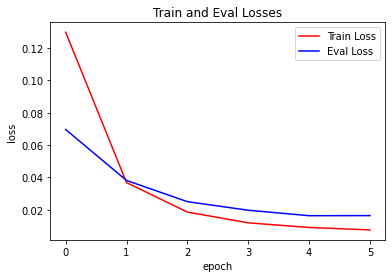

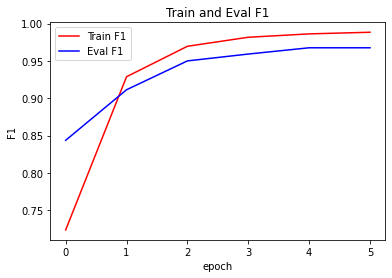

In [27]:
plt.plot(range(n_epochs), epoch_losses, 'r', label='Train Loss')
plt.plot(range(n_epochs), epoch_losses_eval, 'b', label='Eval Loss')
plt.title('Train and Eval Losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.plot(range(n_epochs), epoch_f1, 'r', label='Train F1')
plt.plot(range(n_epochs), epoch_f1_eval, 'b', label='Eval F1')
plt.title('Train and Eval F1')
plt.xlabel('epoch')
plt.ylabel('F1')
plt.legend()
plt.show()

## Demo time !

In [28]:
text = 'what are my alarms for tomorrow?' #@param {type:"string"}

# prepare text ----------------------------------------------------------------
preprocessed = preprocess(text)
indices = [token2idx[token] if token in token2idx else token2idx[UNK] 
           for token in preprocessed.split()]
embeddings = indices + (10 - len(indices)) * [token2idx[PAD]]
embeddings = torch.LongTensor([embeddings]).to(device)
# predict ---------------------------------------------------------------------
with torch.no_grad():
    model.eval()
    prediction = model(embeddings)
# decode ----------------------------------------------------------------------
out = softmax(prediction)
index = torch.argmax(out)
print('Intent >>', all_labels[index])

Intent >> alarm/show_alarms
